In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

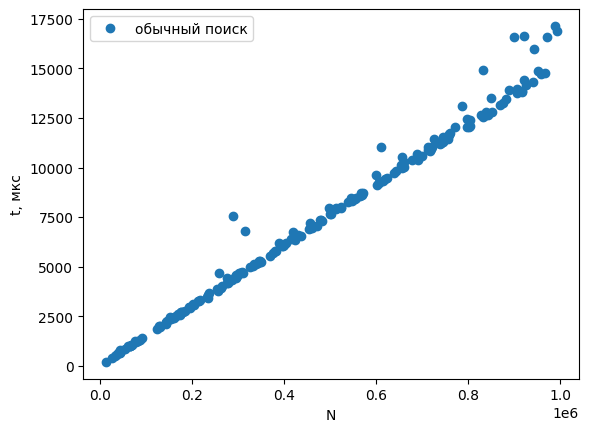

In [19]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data1 = pd.read_csv("simpl_poisk.csv")
plt.plot(data1["N"], data1["t"], "o", label = "обычный поиск")
plt.legend()

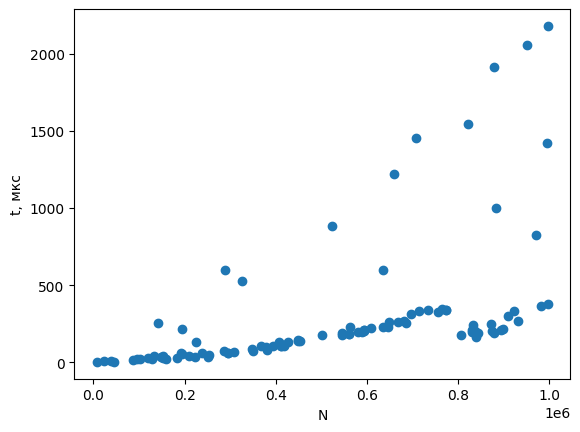

In [20]:
plt.xlabel("N")
plt.ylabel("t, мкс")
data1 = pd.read_csv("bin_poisk.csv")
plt.plot(data1["N"], data1["t"], "o")